In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio

import numpy as np
from matplotlib import pyplot as plt
import cv2

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
to_image = transforms.ToPILImage()

trainset = FashionMNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.n_features = 128
        self.n_out = 784
        self.linear = nn.Sequential(
            nn.Linear(self.n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.linear(x)
        return x.view(-1, 1, 28, 28)
    

class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.n_in = 784
        self.n_out = 1
        self.linear = nn.Sequential(
            nn.Linear(self.n_in, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, self.n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, self.n_in)
        return self.linear(x)

In [19]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [20]:
pretrained = False
if pretrained == True:
    generator.load_state_dict(torch.load('models/fmnist_gen.pth'))
    discriminator.load_state_dict(torch.load('models/fmnist_disc.pth'))

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

criterion = nn.BCELoss()

In [28]:
def create_noise(n, n_features=128):
    return torch.randn(n, n_features).to(device)

def create_label_ones(size):
    return torch.ones(size, 1).to(device)

def create_label_zeros(size):
    return torch.zeros(size, 1).to(device)

In [29]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)
    predication_real = discriminator(real_data)
    d_loss = criterion(predication_real, create_label_ones(n))
    predication_fake = discriminator(fake_data)
    g_loss = criterion(predication_fake, create_label_zeros(n))
    loss = d_loss + g_loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item()

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    prediction = discriminator(fake_data)
    loss = criterion(prediction, create_label_ones(n))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item()

In [23]:
num_epochs = 201
test_noise = create_noise(64)
l = len(train_loader)
g_losses = []
d_losses = []
images = []

for epoch in range(num_epochs):
    g_loss = 0.0
    d_loss = 0.0
    for data in train_loader:
        imgs, _ = data
        n = len(imgs)

        fake_data = generator(create_noise(n)).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(create_noise(n))
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}: g_loss: {g_loss / n:.3f} d_loss: {d_loss / n:.3f}')

torch.save(generator.state_dict(), 'models/fmnist_gen.pth')
torch.save(discriminator.state_dict(), 'models/fmnist_disc.pth')
print('Training Finished')

Epoch 0: g_loss: 3.268 d_loss: 4.566
Epoch 10: g_loss: 2.681 d_loss: 5.715
Epoch 20: g_loss: 2.334 d_loss: 6.565
Epoch 30: g_loss: 2.299 d_loss: 6.711
Epoch 40: g_loss: 2.308 d_loss: 6.621
Epoch 50: g_loss: 2.320 d_loss: 6.602
Epoch 60: g_loss: 2.309 d_loss: 6.645
Epoch 70: g_loss: 2.258 d_loss: 6.768
Epoch 80: g_loss: 2.306 d_loss: 6.645
Epoch 90: g_loss: 2.249 d_loss: 6.790
Epoch 100: g_loss: 2.247 d_loss: 6.788
Epoch 110: g_loss: 2.239 d_loss: 6.812
Epoch 120: g_loss: 2.221 d_loss: 6.854
Epoch 130: g_loss: 2.214 d_loss: 6.873
Epoch 140: g_loss: 2.208 d_loss: 6.874
Epoch 150: g_loss: 2.184 d_loss: 6.951
Epoch 160: g_loss: 2.205 d_loss: 6.924
Epoch 170: g_loss: 2.174 d_loss: 6.986
Epoch 180: g_loss: 2.155 d_loss: 7.011
Epoch 190: g_loss: 2.185 d_loss: 6.970
Epoch 200: g_loss: 2.148 d_loss: 7.033
Training Finished


In [26]:
imgs = [np.array(to_image(i))for i in images]
imageio.mimsave('results/fashion_items_gan.gif', imgs)

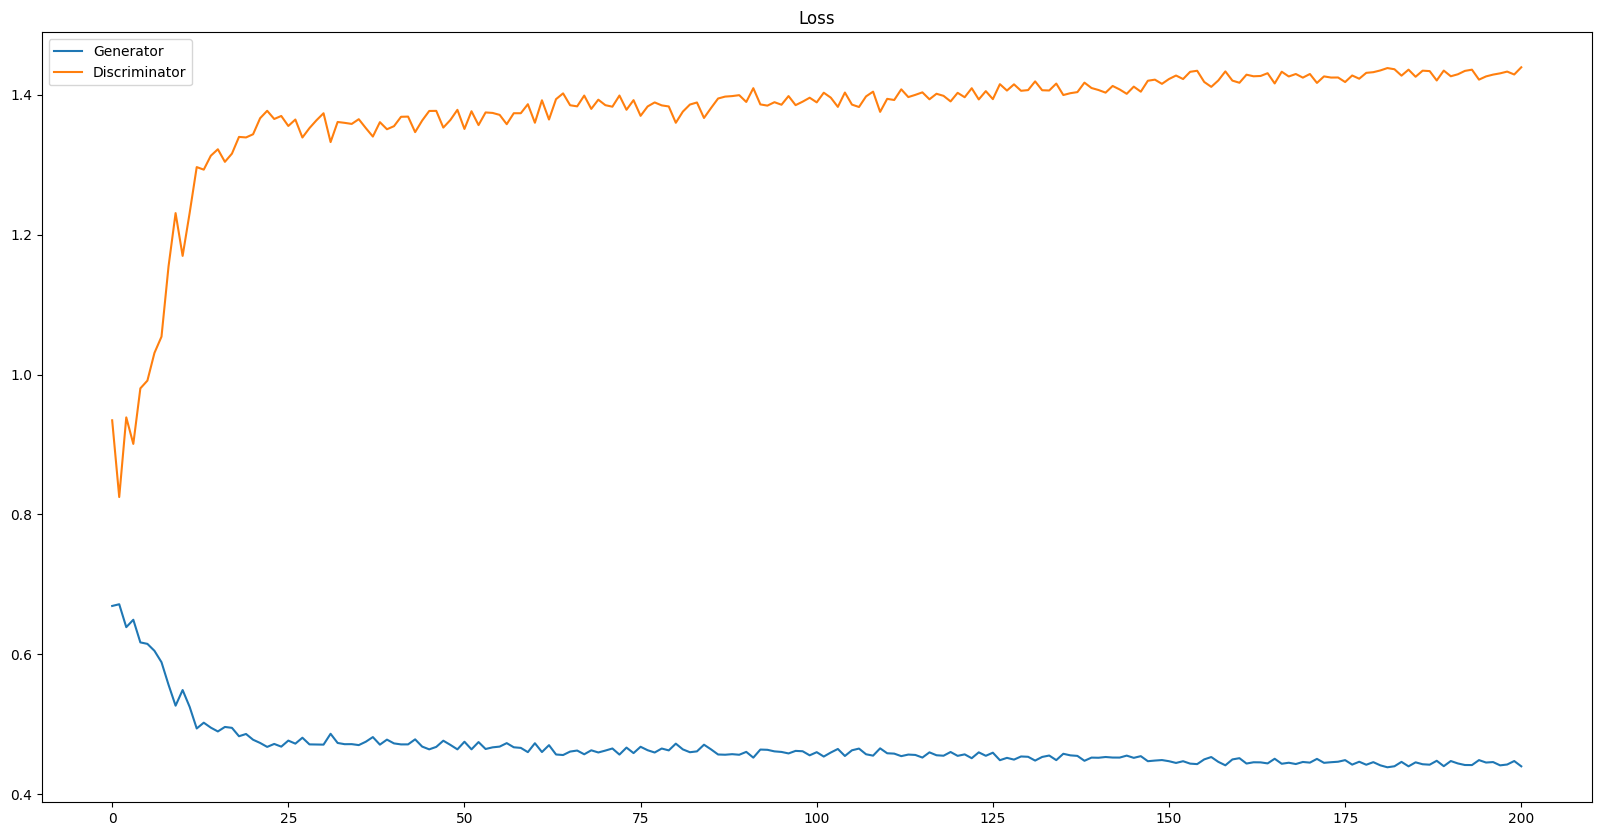

In [27]:
plt.figure(figsize=(20, 10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator', 'Discriminator'])
plt.title('Loss')
plt.savefig('results/gan_loss.png')